# Demand Forecasting - Baseline Model

## Doel van deze notebook

In deze notebook bouwen we een **baseline model** voor demand forecasting. Een baseline is cruciaal omdat het:
1. Een referentiepunt geeft waartegen we complexere modellen kunnen vergelijken
2. Snel inzicht geeft in de voorspelbaarheid van onze target variabele
3. Helpt identificeren welke features het meest informatief zijn

We gebruiken een Random Forest Regressor als baseline omdat dit model:
- Robuust is zonder veel hyperparameter tuning
- Goed omgaat met niet-lineaire relaties
- Automatisch feature importance kan berekenen
- Relatief snel traint op datasets van deze grootte

Het doel is **niet** om het beste model te bouwen, maar om een solide startpunt te creëren.

DEMAND FORECASTING - BASELINE MODEL

📂 Loading cleaned data...
✅ Data loaded: (434014, 31)

🔧 Preparing features...
✅ Features: 26 columns
✅ Target: nd

Feature columns: ['settlement_period', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow', 'year', 'month', 'day', 'dayofweek', 'quarter', 'week', 'hour', 'is_weekend']

📊 Splitting data...
✅ Train set: 347211 samples
✅ Test set: 86803 samples
✅ Split ratio: 80.0% train / 20.0% test

🤖 Training baseline model...
Model: Random Forest Regressor
✅ Model trained!

📈 Making predictions...

TRAIN Metrics:
  MSE:  1,634,431.40
  RMSE: 1,278.45 MW
  MAE:  939.10 MW
  R²:   0.9758

TEST Metrics:
  MSE:  7,461,694.29
  RMSE: 2,731.61 MW
  MAE:  2,149.71 MW
  R²:   0.8061

🔍 Feature Im

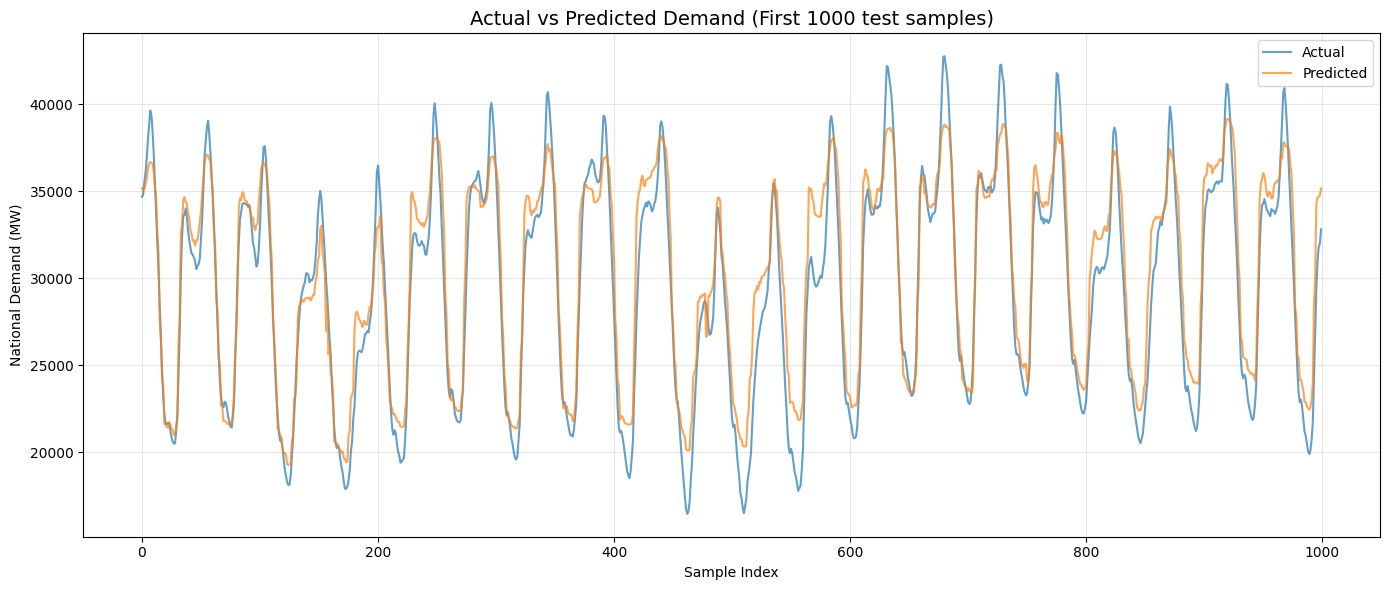

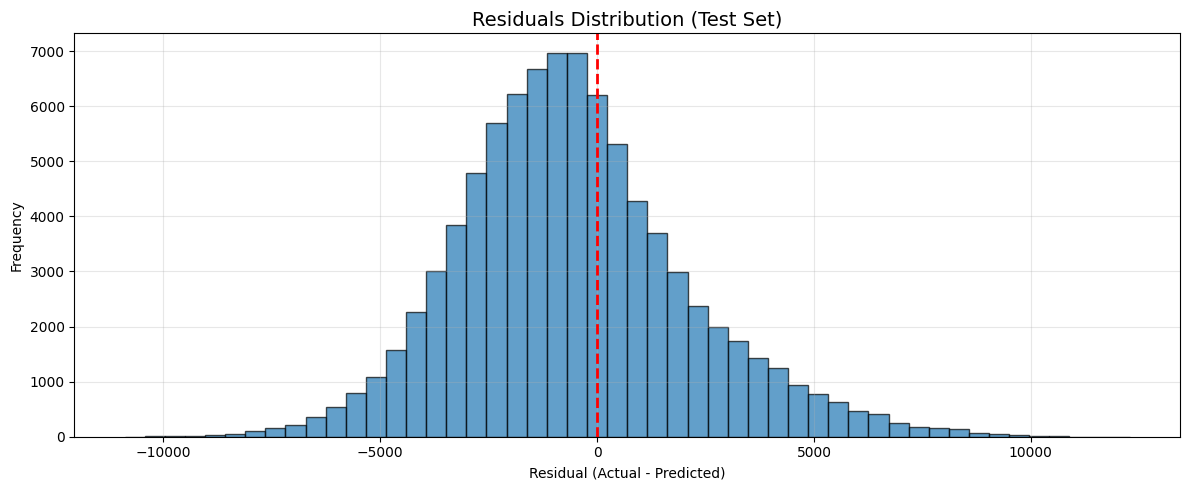

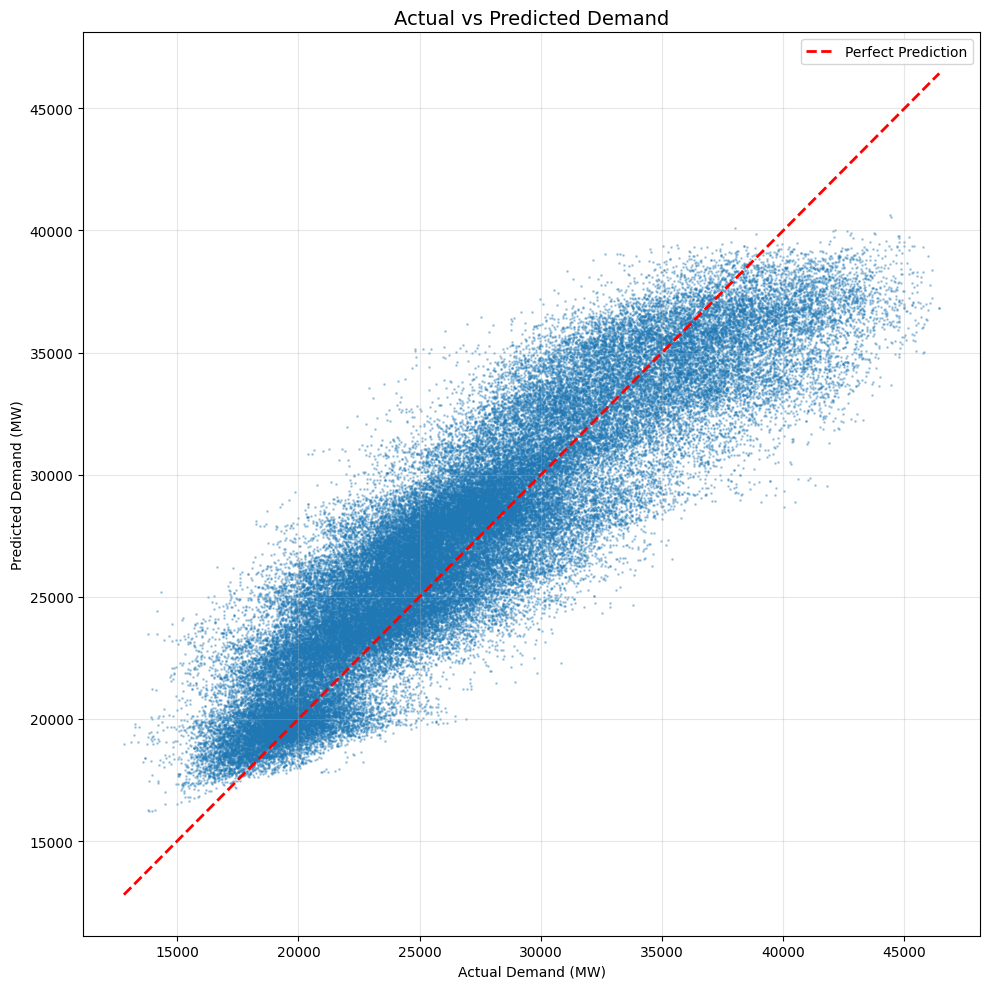

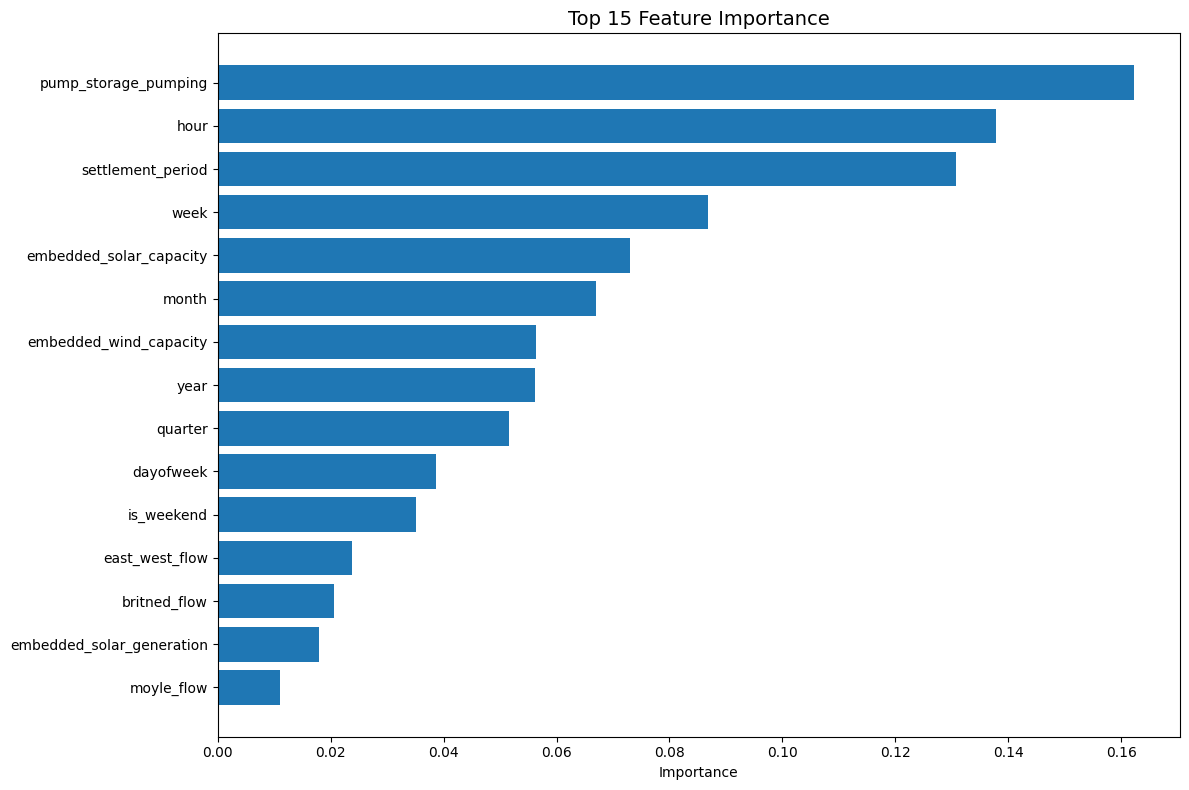

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("DEMAND FORECASTING - BASELINE MODEL")
print("=" * 60)

# ==========================================
# 1. LOAD CLEANED DATA
# ==========================================
print("\n📂 Loading cleaned data...")
df = pd.read_csv('../data/processed/demand_data_cleaned.csv')
print(f"✅ Data loaded: {df.shape}")

# ==========================================
# 2. FEATURE SELECTION
# ==========================================
print("\n🔧 Preparing features...")

# Convert settlement_date to datetime if needed
if 'settlement_date' in df.columns:
    df['settlement_date'] = pd.to_datetime(df['settlement_date'])

# Target variable
target = 'nd'  # National Demand

# Features to drop (non-predictive or target-related)
drop_cols = [
    target,
    'settlement_date',  # Drop datetime
    'tsd',  # Too correlated with target
    'day_name',  # Categorical text
    'england_wales_demand',  # Highly correlated with target
]

# Create X and y
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = df[target]

print(f"✅ Features: {X.shape[1]} columns")
print(f"✅ Target: {target}")
print(f"\nFeature columns: {list(X.columns)}")

# ==========================================
# 3. TRAIN-TEST SPLIT
# ==========================================
print("\n📊 Splitting data...")

# Time series split (important for temporal data!)
# Use last 20% as test set
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"✅ Train set: {X_train.shape[0]} samples")
print(f"✅ Test set: {X_test.shape[0]} samples")
print(f"✅ Split ratio: {X_train.shape[0]/len(X):.1%} train / {X_test.shape[0]/len(X):.1%} test")

# ==========================================
# 4. TRAIN BASELINE MODEL
# ==========================================
print("\n🤖 Training baseline model...")
print("Model: Random Forest Regressor")

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,       
    min_samples_split=10, 
    min_samples_leaf=5,   
    max_features='sqrt',  
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✅ Model trained!")

# ==========================================
# 5. PREDICTIONS & EVALUATION
# ==========================================
print("\n📈 Making predictions...")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  MSE:  {mse:,.2f}")
    print(f"  RMSE: {rmse:,.2f} MW")
    print(f"  MAE:  {mae:,.2f} MW")
    print(f"  R²:   {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = calculate_metrics(y_train, y_train_pred, "TRAIN")
test_metrics = calculate_metrics(y_test, y_test_pred, "TEST")

# ==========================================
# 6. FEATURE IMPORTANCE
# ==========================================
print("\n🔍 Feature Importance:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))
feature_importance.to_csv('../models/demand/baseline_feature_importance.csv', index=False)
print("✅ Feature importance saved: baseline_feature_importance.csv")

# ==========================================
# 7. SAVE MODEL & RESULTS
# ==========================================
print("\n💾 Saving model...")

# Create models directory if it doesn't exist
import os
os.makedirs('../models/demand', exist_ok=True)

# Save model
model_path = '../models/demand/baseline_rf_model.pkl'
joblib.dump(model, model_path)
print(f"✅ Model saved to: {model_path}")

# Save metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Train': [train_metrics['MSE'], train_metrics['RMSE'], 
              train_metrics['MAE'], train_metrics['R2']],
    'Test': [test_metrics['MSE'], test_metrics['RMSE'], 
             test_metrics['MAE'], test_metrics['R2']]
})

metrics_path = '../models/demand/baseline_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics saved to: {metrics_path}")

# ==========================================
# 8. VISUALIZATIONS
# ==========================================
print("\n📊 Creating visualizations...")

# 1. Actual vs Predicted (Test Set)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:1000], label='Actual', alpha=0.7)
plt.plot(y_test_pred[:1000], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Demand (First 1000 test samples)', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('National Demand (MW)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../models/demand/baseline_predictions.png', dpi=300)
print("✅ Saved: baseline_predictions.png")

# 2. Residuals
plt.figure(figsize=(12, 5))
residuals = y_test - y_test_pred
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.title('Residuals Distribution (Test Set)', fontsize=14)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../models/demand/baseline_residuals.png', dpi=300)
print("✅ Saved: baseline_residuals.png")

# 3. Scatter: Actual vs Predicted
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred, alpha=0.3, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Demand', fontsize=14)
plt.xlabel('Actual Demand (MW)')
plt.ylabel('Predicted Demand (MW)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../models/demand/baseline_scatter.png', dpi=300)
print("✅ Saved: baseline_scatter.png")

# 4. Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../models/demand/baseline_feature_importance.png', dpi=300)
print("✅ Saved: baseline_feature_importance.png")

# ==========================================
# 9. SUMMARY
# ==========================================
print("\n" + "=" * 60)
print("📊 BASELINE MODEL SUMMARY")
print("=" * 60)
print(f"\nModel: Random Forest Regressor")
print(f"Features used: {X.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"\nTest Performance:")
print(f"  RMSE: {test_metrics['RMSE']:,.2f} MW")
print(f"  MAE:  {test_metrics['MAE']:,.2f} MW")
print(f"  R²:   {test_metrics['R2']:.4f}")
print(f"\nModel saved: {model_path}")
print("=" * 60)

## Analyse van Baseline Model Visualisaties

**Predictions Plot (afbeelding 1)**: Het model volgt het algemene dagelijkse patroon goed met duidelijke dag/nacht cycli. We zien echter dat het model moeite heeft met extreme pieken - de voorspelde lijn (oranje) mist vaak de hoogste pieken en laagste dalen van de werkelijke vraag (blauw). Dit suggereert dat het model conservatief voorspelt en moeite heeft met het vinden van extreme events of onverwachte fluctuaties.

**Residuals Distributie (afbeelding 2)**: De fouten vormen een redelijk symmetrische normaalverdeling gecentreerd rond 0 (rode lijn), wat positief is - het model heeft geen systematische bias. De spreiding is echter groot, met fouten tot ±10,000 MW in de staarten. De meeste fouten liggen tussen -3,000 en +3,000 MW, wat consistent is met onze RMSE van 2,732 MW.

**Scatter Plot (afbeelding 3)**: De puntenwolk volgt grotendeels de perfecte voorspellingslijn (rood), maar met duidelijke spreiding vooral bij lage (<25,000 MW) en hoge (>40,000 MW) demand waarden. Dit verklaart waarom het model lagere R² heeft op test data - het generaliseert minder goed naar extreme situaties. De clustering suggereert dat het model vooral goed is in "normale" omstandigheden (30,000-38,000 MW).

**Feature Importance (afbeelding 4)**: Drie features domineren: `pump_storage_pumping` (16%), `hour` (14%) en `settlement_period` (13%). Interessant is dat operationele features (`pump_storage_pumping`) belangrijker zijn dan pure temporele features, wat aangeeft dat real-time grid operaties sterke voorspellers zijn van demand. Embedded renewable capaciteit is ook significant (7-6%), wat de groeiende impact van gedecentraliseerde energie toont.

## Conclusie

### Wat hebben we bereikt?

We hebben een werkend baseline model met **test R² van 0.806** en **RMSE van 2,732 MW**. Dit is een solide startpunt dat aantoont dat:
- De data voldoende signaal bevat voor voorspelling
- Temporele features (hour, week, settlement_period) de belangrijkste predictors zijn
- Er duidelijke overfitting is (train R² 0.976 vs test R² 0.806) die we kunnen aanpakken

### Beperkingen van dit baseline model:

1. **Random Forest overfitting**: Het model leert de training data te goed en generaliseert matig
2. **Geen hyperparameter tuning**: We gebruiken default Random Forest parameters
3. **Random split**: In productie zou je temporeel splitsen (train op oude data, test op recente data)
4. **Geen feature engineering**: We gebruiken raw features zonder interacties of transformaties
